In [1]:
# In this notebook we build the antialiased cylinder data 
# and the function to pad it with absorbing boundary conditions.

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from jax import Array
from scipy.special import factorial

import chromatix.functional as cf

%config InlineBackend.figure_format='retina'

# 3D grid

In [2]:
def sample_grid(size: tuple[int, int, int]) -> Array:
    N_z, N_y, N_x = size

    grid = jnp.meshgrid(
            jnp.linspace(-N_z // 2, N_z // 2 - 1, num=N_z) + 0.5,
            jnp.linspace(N_y // 2, -N_y // 2 - 1, num=N_y) + 0.5,
            jnp.linspace(-N_x // 2, N_x // 2 - 1, num=N_x) + 0.5,
            indexing="ij",
        )

    return jnp.stack(grid, axis=-1)

In [3]:
grid = sample_grid((128, 128, 128))

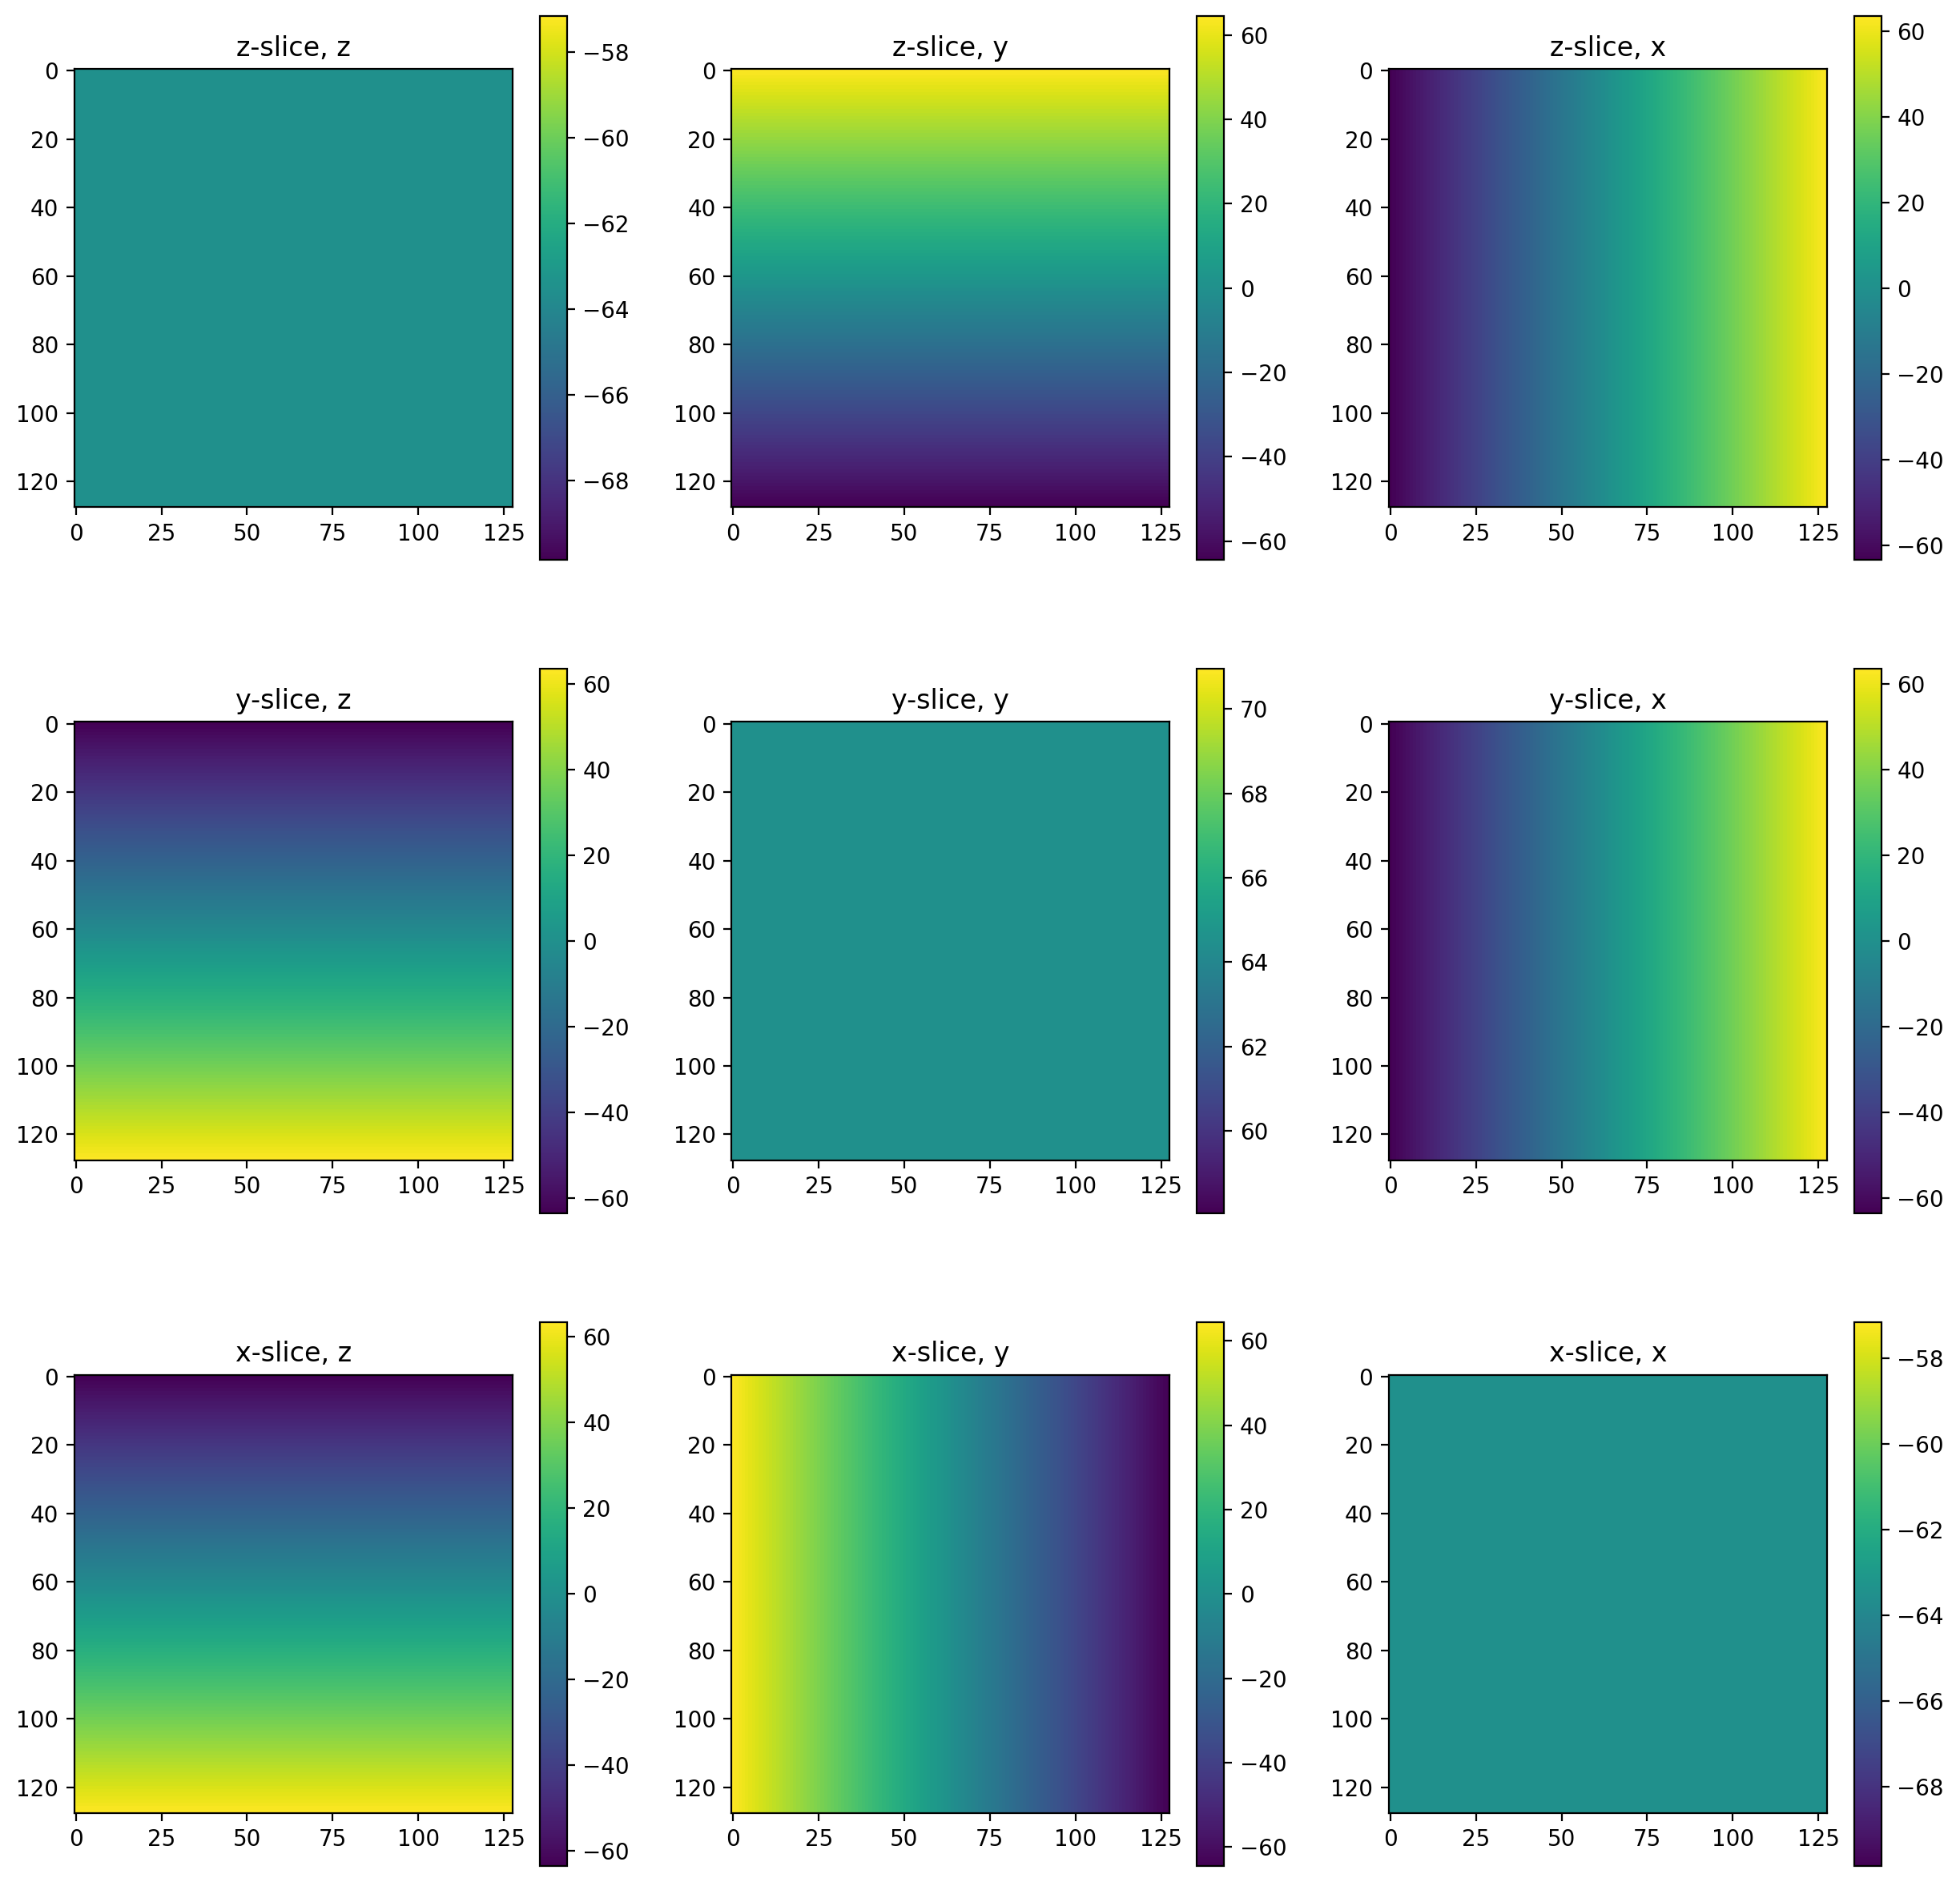

In [4]:
plt.figure(figsize=(15, 15))

plt.subplot(331)
plt.title("z-slice, z")
plt.imshow(grid[0, :, :, 0])
plt.colorbar()

plt.subplot(332)
plt.title("z-slice, y")
plt.imshow(grid[0, :, :, 1])
plt.colorbar()

plt.subplot(333)
plt.title("z-slice, x")
plt.imshow(grid[0, :, :, 2])
plt.colorbar()

plt.subplot(334)
plt.title("y-slice, z")
plt.imshow(grid[:, 0, :, 0])
plt.colorbar()

plt.subplot(335)
plt.title("y-slice, y")
plt.imshow(grid[:, 0, :, 1])
plt.colorbar()

plt.subplot(336)
plt.title("y-slice, x")
plt.imshow(grid[:, 0, :, 2])
plt.colorbar()

plt.subplot(337)
plt.title("x-slice, z")
plt.imshow(grid[:, :, 0, 0])
plt.colorbar()

plt.subplot(338)
plt.title("x-slice, y")
plt.imshow(grid[:, :, 0, 1])
plt.colorbar()

plt.subplot(339)
plt.title("x-slice, x")
plt.imshow(grid[:, :, 0, 2])
plt.colorbar()

In [5]:
del grid

# Making anti-aliased sample

In [6]:
def cylinders(size: tuple[int, int, int], 
              spacing: float, 
              location: Array, 
              radius: float, 
              n_background: float, 
              n_cylinder: float,
              antialiasing: int | None = 10) -> Array:

    # Making the grid, in 2D
    N_z, N_y, N_x = size

    if antialiasing is not None:
        N_z, N_x = N_z * antialiasing, N_x * antialiasing
        spacing = spacing / antialiasing
    
    grid = spacing * sample_grid((N_z, 1, N_x)).squeeze(1)[..., [0, 2]]

    # Making mask
    mask = jnp.zeros((N_z, N_x))
    for cylinder in location:
        mask += jnp.linalg.norm(grid - cylinder, axis=-1) < radius

    sample = jnp.where(mask == 1.0, n_cylinder, n_background)
    if antialiasing is not None:
        sample = reduce(sample, f"(z {antialiasing}) (x {antialiasing}) -> z x", "mean")

    # Setting index
    sample = jnp.repeat(sample[:, None, :, None, None], N_y, axis=1)
    return sample
    

In [35]:
cylinder_locs = jnp.array([[-44.5, -44.5], 
                           [44.5, -44.5],
                           [44.5, 44.5], 
                           [20.6, -18.0],
                           [-10.4, 18.1]])

cylinder_radius = 5.0
n_cylinder = 1.36
n_mat = 1.33
wavelength = 0.532
sim_size = 100
sim_shape = (256, 256, 256)
spacing = sim_size / sim_shape[0]
print(f"Number of cells per wavelength: {wavelength / spacing}")
k0 = 2 * jnp.pi * n_mat/ wavelength


sample = cylinders(sim_shape, 
                   spacing, 
                   cylinder_locs,
                   cylinder_radius,
                   n_mat, 
                   n_cylinder, antialiasing=10)

Number of cells per wavelength: 1.36192


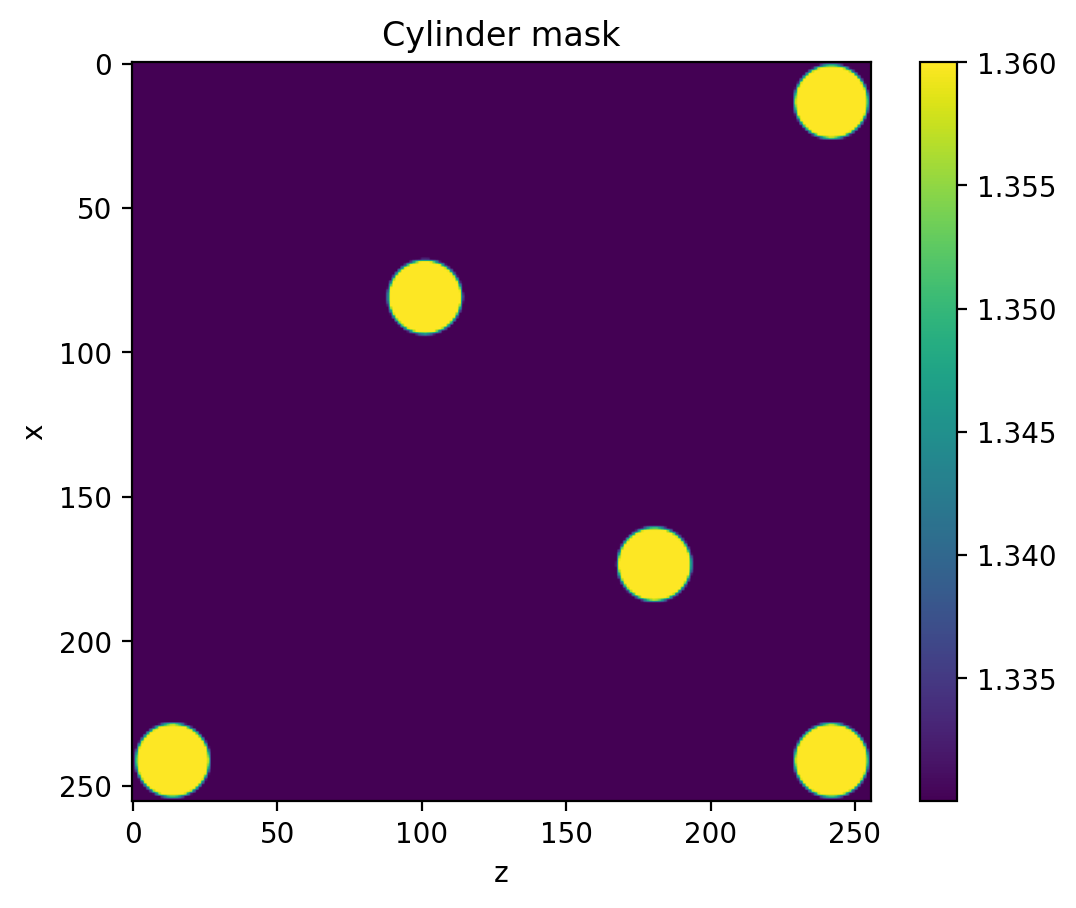

In [36]:
plt.imshow(jnp.rot90(sample[:, 10].squeeze(), 1))
plt.xlabel("z")
plt.ylabel("x")
plt.title("Cylinder mask")
plt.colorbar()
plt.show()

In [37]:
sample.shape

(256, 256, 256, 1, 1)

In [38]:
# From refractive index to potential
# Getting free parameters
delta = jnp.max((2 * jnp.pi * sample / wavelength)**2 - k0**2) + 1e-6 # 1e-6 as epsilon
print(f"Delta is {delta:.2f}")

potential = (2* jnp.pi * sample / wavelength) **2 - k0**2 - 1j * delta

Delta is 11.26


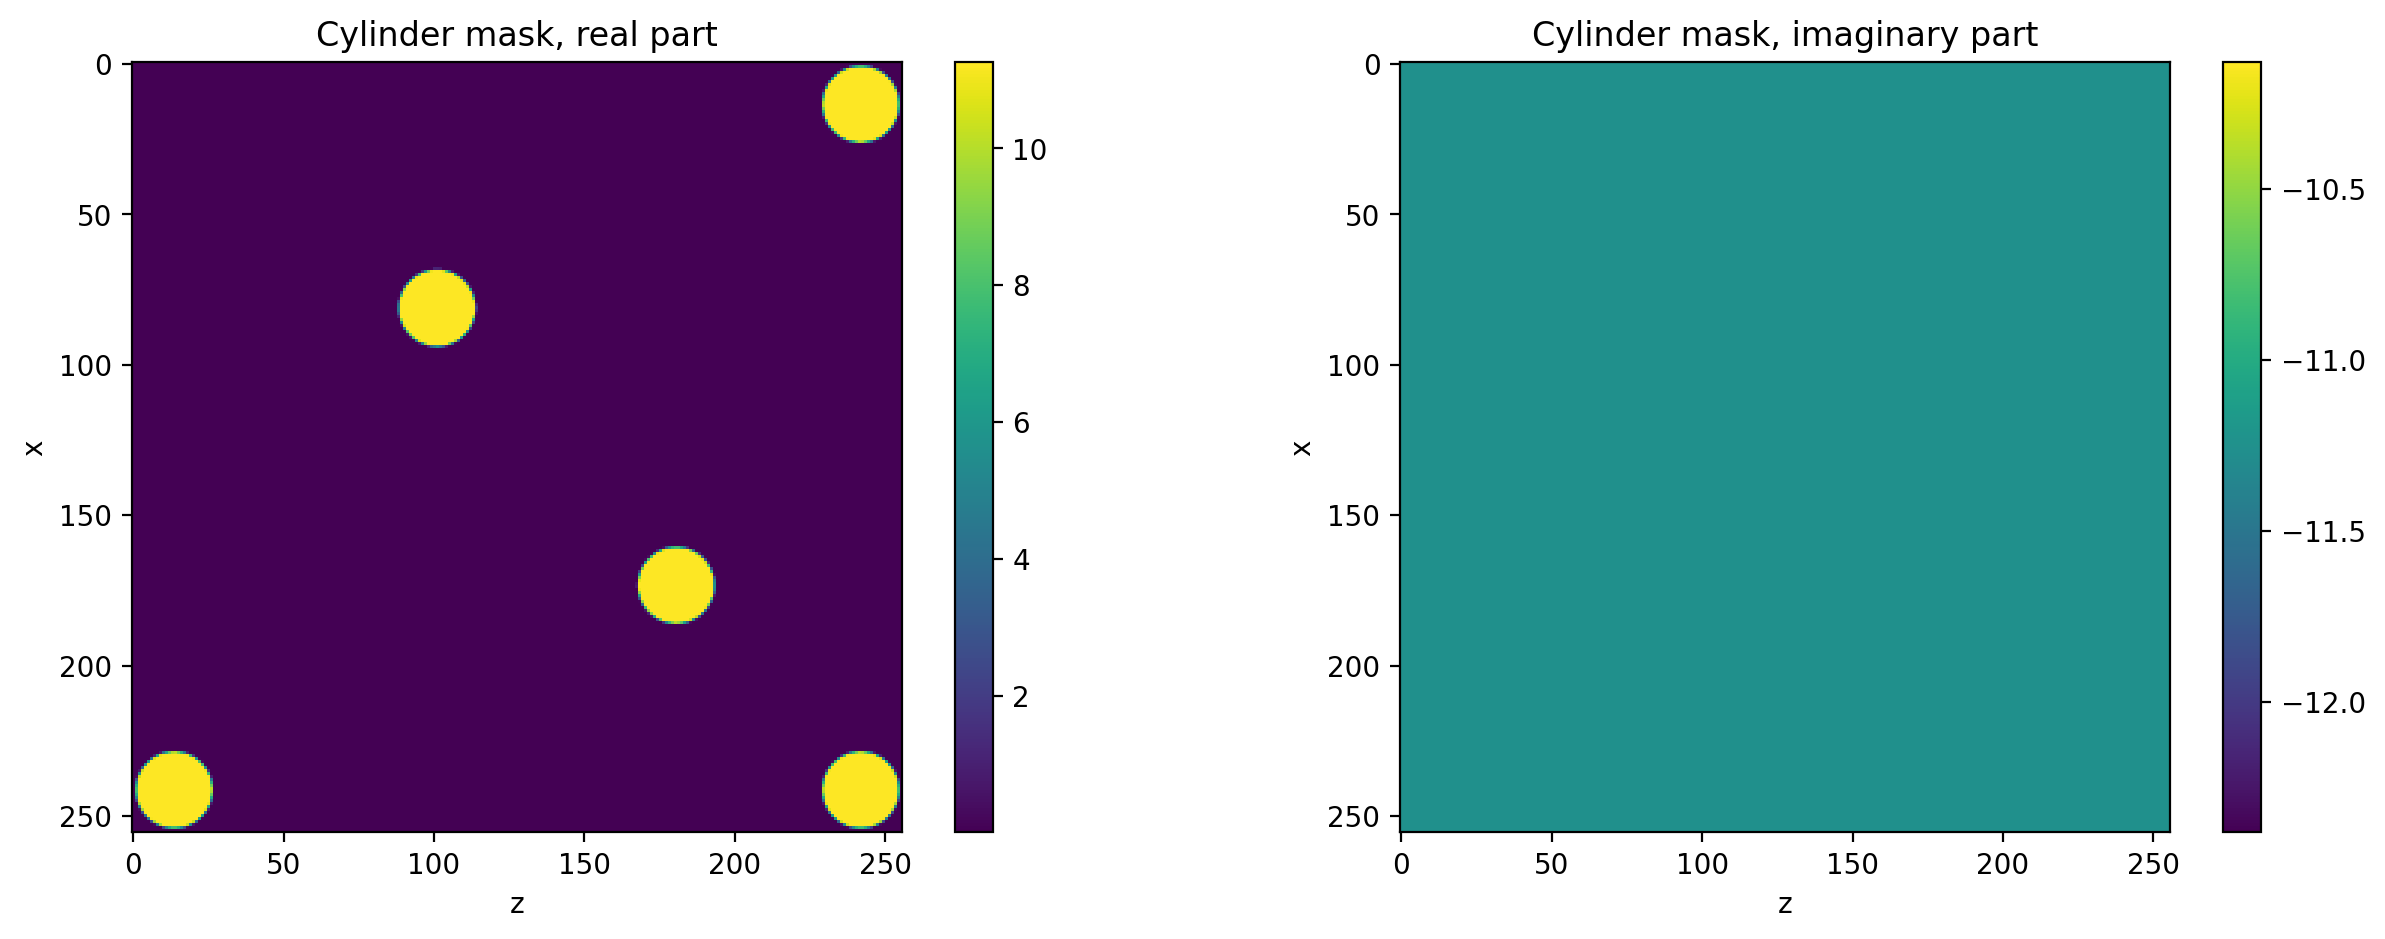

In [39]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(jnp.rot90(jnp.real(potential[:, 10]).squeeze(), 1))
plt.xlabel("z")
plt.ylabel("x")
plt.title("Cylinder mask, real part")
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.rot90(jnp.imag(potential[:, 10]).squeeze(), 1))
plt.xlabel("z")
plt.ylabel("x")
plt.title("Cylinder mask, imaginary part")
plt.colorbar()

plt.show()

# Boundary conditions

In [40]:
def add_absorbing_boundary(potential, spacing: float, N_padding: int, alpha: float, N: int, k0: float):
    # Making distance grid
    size = sample.shape[:3]
    
    radius = spacing * size[0] / 2
    grid = spacing * sample_grid(tuple(N + 2 * N_padding for N in size))
    mask = jnp.linalg.norm(grid, jnp.inf, axis=-1)
    d = jnp.where(mask < radius, 0, mask - radius) 

    # Making boundary
    def Pn(N):
        ax = alpha *  d
        p = jnp.zeros_like(d)
        for i in range(N+1):
            p += ax ** i / factorial(i, exact=True)
        return p

    numerator = alpha**2 * (N - alpha * d + 2 * 1j * k0 * d) * (alpha * d) **(N-1)
    denominator = Pn(N) * factorial(N, exact=True)
    absorbing_boundary = numerator / denominator

    padded_sample = jnp.pad(potential.squeeze((-2, -1)), N_padding)
    return padded_sample + absorbing_boundary


In [41]:
padding = int(25 / spacing)
print(f"Padding is {padding}")

Padding is 64


In [42]:
padded_potential = add_absorbing_boundary(potential, spacing, padding, alpha=0.35, N=4, k0=k0)
print(padded_potential.shape)

(384, 384, 384)


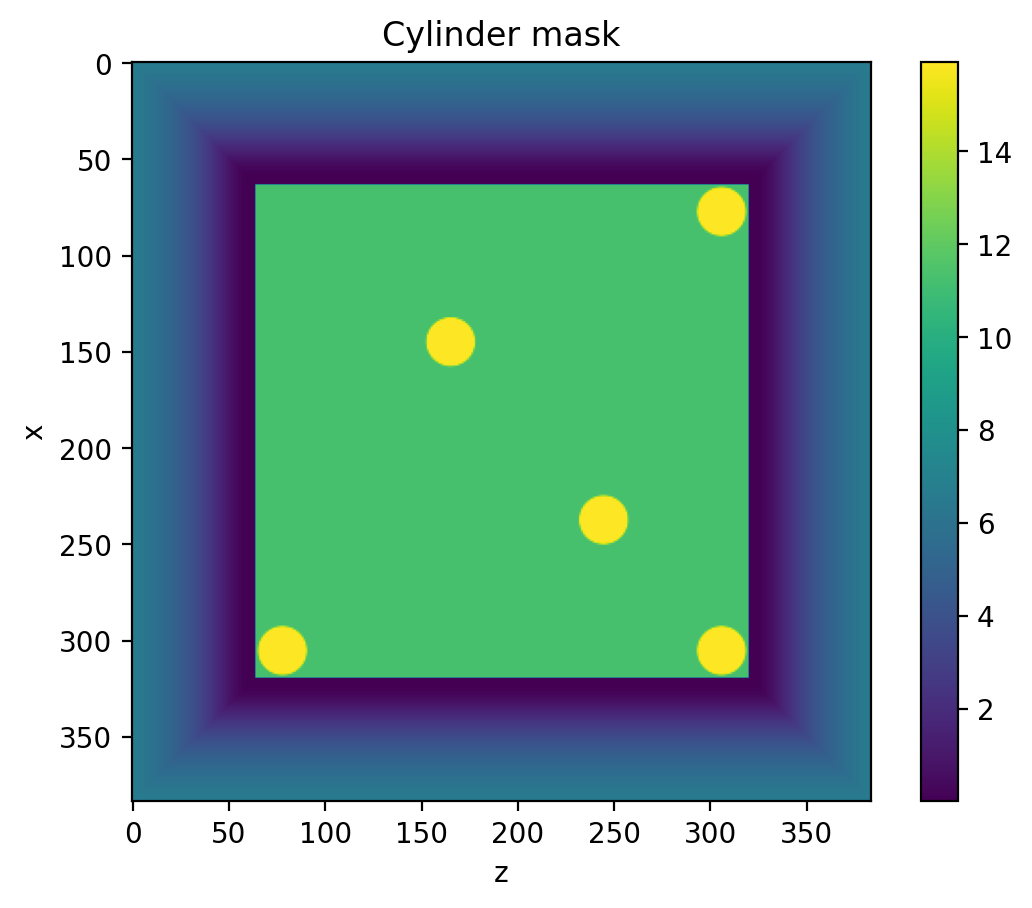

In [43]:
plt.imshow(jnp.abs(jnp.rot90(padded_potential[:, 10 + 64].squeeze(), 1)))
plt.xlabel("z")
plt.ylabel("x")
plt.title("Cylinder mask")
plt.colorbar()
plt.show()

# Solving

In [44]:
sample.shape

(256, 256, 256, 1, 1)

In [45]:
padded_potential = potential

In [46]:
# Init field
field = cf.plane_wave(sample.shape[1:3], 
                      spacing, 
                      wavelength, 
                      spectral_density=1.0)

In [47]:
# We also need a field s for the sources 
s = jnp.zeros(sample.shape, dtype=jnp.complex64)
s = s.at[0].set(field.u[0])
s = s * (k0**2 - (2*jnp.pi * sample / wavelength)**2)

# We make a field similar to the scattering field
#s = jnp.pad(s.squeeze((-2, -1)), padding)[..., None, None] 
u = s

In [48]:
# Making k grid
shape = jnp.array(s.shape[:3])
dk = 1 / (spacing * shape)
N_z, N_y, N_x = padded_potential.shape[:3]

#
k_grid = jnp.meshgrid(
            jnp.linspace(-N_z // 2, N_z // 2 - 1, num=N_z) + 0.5,
            jnp.linspace(-N_y // 2, N_y // 2 - 1, num=N_y) + 0.5,
            jnp.linspace(-N_x // 2, N_x // 2 - 1, num=N_x) + 0.5,
            indexing="ij",
        )
k_grid = jnp.fft.ifftshift(dk * rearrange(k_grid, "c d h w -> d h w c"))

In [49]:
# Making G
G = 1 / (jnp.sum(k_grid**2, axis=-1)[..., None, None] - k0**2 - 1j * delta)
gamma = 1j / delta * padded_potential

@jax.jit
def update(G, V, u, s):
    r = jnp.fft.ifftn(G * jnp.fft.fftn(V * u + s, axes=(0, 1, 2)), axes=(0, 1, 2)) - u 
    return u + gamma * r, {"absolute error": jnp.max(jnp.abs(r))}

In [50]:
for iteration in range(2000):
    u, error = update(G, padded_potential, u, s)
    if iteration % 50 == 0:
        print(error)

{'absolute error': Array(5.3566837e-06, dtype=float32)}
{'absolute error': Array(1.12229434e-10, dtype=float32)}
{'absolute error': Array(1.122245e-10, dtype=float32)}
{'absolute error': Array(1.12210796e-10, dtype=float32)}


KeyboardInterrupt: 

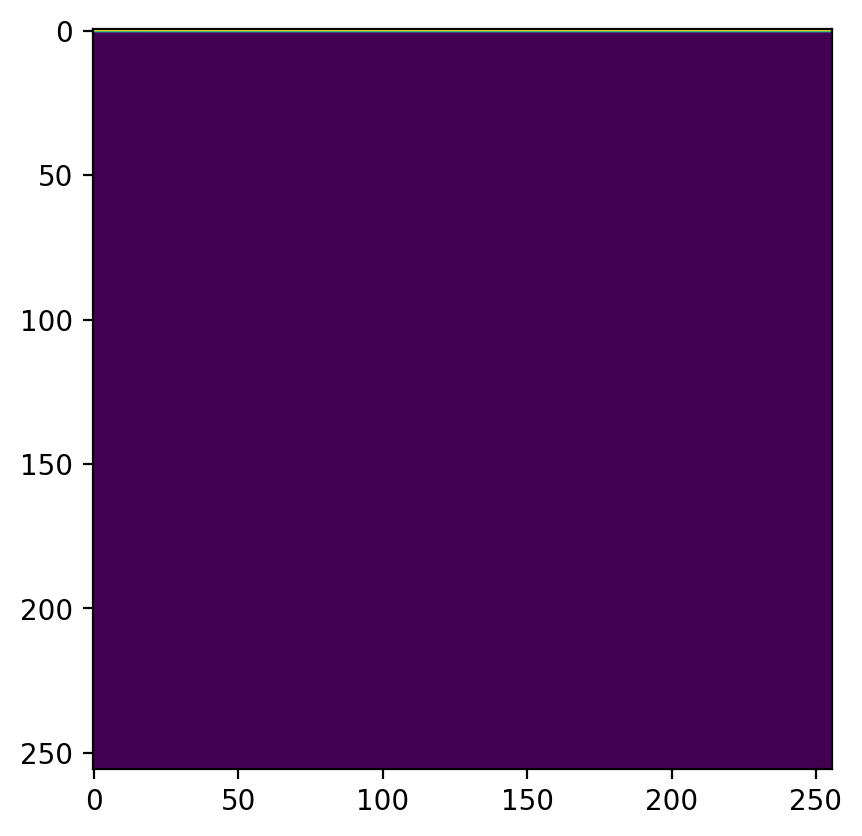

In [51]:
plt.imshow(jnp.abs(u[:, 10 + padding]).squeeze())

In [46]:
padding

64